# Simple keyword spotting with CMSIS-DSP Python wrapper and Arduino

The goal of this notebook is to demonstrate how to use the CMSIS-DSP Python wrapper on an example which is complex enough.

It is not a state of the art keyword recognition system. The feature used for the machine learning is very simple and just able to recognize the "Yes" keyword.

But it is a good start and enough to demonstrate lots of features of the Python wrapper like:

* Testing the CMSIS-DSP algorithm directly in Python
* Test of fixed point implementation
* Implementation of the compute graph and streaming computation from the CMSIS-DSP Synchronous Data Flow framework
* C++ code generation for the compute graph
* Final implementation for Arduino Nano 33 BLE

Several Python packages are required. If they are not already installed on you system, you can install them from the notebook by using:

`!pip install packagename`

The machine learning is using scikit-learn. For scientific computations, we are using SciPy, NumPy and Matplotlib.

For reading wav files, the soundfile package is used.

Other packages will be used below in the notebook and will have to be installed.

In [1]:
import cmsisdsp as dsp
import cmsisdsp.fixedpoint as fix
import numpy as np
import os.path
import glob
import pathlib
import random
import soundfile as sf
import matplotlib.pyplot as plt
from IPython.display import display,Audio,HTML
import scipy.signal
from numpy.lib.stride_tricks import sliding_window_view
from scipy.signal.windows import hann
from sklearn import svm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.linear_model import LogisticRegression
import pickle

## The speech commands

We are using the simplified speech commands from the TensorFlow Lite tutorial.

Those commands can be downloaded from this link: "http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip"

Once the zip has been uncompressed, you'll need to change the path of the folder below.

The below code is loading the list of commands available in the `mini_speech_commands` folder and it is describing the words we want to detect. Here we only want to detect the `Yes` keyword.

You can add other keywords but the CMSIS-DSP implementation in this notebook is only supporting one keyword.
Nevertheless, if you'd like to experiment with the training of the ML model and different features, then you can work with more commands.

In [7]:
MINISPEECH="C:/Users/chrfav01/benchresults/mini_speech_commands"
commands=np.array([os.path.basename(f) for f in glob.glob(os.path.join(MINISPEECH,"mini_speech_commands","*"))])
commands=commands[commands != "README.md"]
# Any other word will be recognized as unknown
to_keep=['yes']

In [8]:
commands.shape

(8,)

The below code is generating a label ID for a command. The ID will be -1 for any command not in the `to_keep` list. Other ID will be the index of the keyword in this list.

In [9]:
UNKNOWN_CLASS = -1
def get_label(name):
    return(pathlib.PurePath(name).parts[-2])
def get_label_id(name):
    label=get_label(name)
    if label in to_keep:
        return(to_keep.index(label))
    else:
        return(UNKNOWN_CLASS)

## The feature

The feature is based on a simple zero crossing rate (zcr). We choose to only keep the increasing crossing. I don't think it is making a lot of differences for the final performance of the keyword recognition.

The `zcr` function is computing the zcr for a window of samples.

In [10]:
def zcr(w):
    w = w-np.mean(w)
    f=w[:-1]
    g=w[1:]
    k=np.count_nonzero(np.logical_and(f*g<0, g>f))
    return(1.0*k/len(f))
        

The final feature is the zcr computed on a segment of 1 second and filtered. We are using a sliding window and using a Hann window.

In [11]:
def feature(data):
    samplerate=16000
    input_len = 16000
    
    # The speech pattern is padded to ensure it has a duration of 1 second
    
    waveform = data[:input_len]
    
    zero_padding = np.zeros(
      16000 - waveform.shape[0],
      dtype=np.float32)
   
   
    signal = np.hstack([waveform, zero_padding])
    
    
    # We decompose the intput signal into overlapping window. And the signal in each window
    # is premultiplied by a Hann window of the right size.
    # Warning : if you change the window duration and audio offset, you'll need to change the value
    # in the scripts used for the scheduling of the compute graph later.
    winDuration=25e-3
    audioOffsetDuration=10e-3
    winLength=int(np.floor(samplerate*winDuration))
    audioOffset=int(np.floor(samplerate*audioOffsetDuration))
    overlap=winLength-audioOffset
    window=hann(winLength,sym=False)
    reta=[zcr(x*window) for x in sliding_window_view(signal,winLength)[::audioOffset,:]]
    
    # The final signal is filtered. We have tested several variations on the feature. This filtering is
    # improving the recognition
    reta=scipy.signal.lfilter(np.ones(10)/10.0,[1],reta)
    return(np.array(reta))

## The patterns

The below class is representing a Pattern. A pattern can either be a sound file from the TensorFlow Lite examples and in this case we compute the feature and the label id.

The pattern can also be a random white noise. In that case, we also compute the feature and the class id is -1.

Note that when you use the signal property, the speech patterns will return the content of the file but noise patterns will generate a random noise which will thus be different each time.

In [12]:
class Pattern:
    def __init__(self,p):
        global UNKNOWN_CLASS
        if isinstance(p, str):
            self._isFile=True 
            self._filename=p
            self._label=get_label_id(p)
    
            data, samplerate = sf.read(self._filename)
            self._feature = feature(data)
        else:
            self._isFile=False
            self._noiseLevel=p
            self._label=UNKNOWN_CLASS
            
            noise=np.random.randn(16000)*p
            self._feature=feature(noise)
            
    @property
    def label(self):
        return(self._label)
            
    @property
    def feature(self):
        return(self._feature)
        
        
    # Only useful for plotting
    # The random pattern will be different each time
    @property
    def signal(self):
        if not self._isFile:
            return(np.random.randn(16000)*self._noiseLevel)
        else:
            data, samplerate = sf.read(self._filename)
            return(data)
        

Following code is giving the number of speech samples for each keyword.
It is assuming that all keywords contain the same number of samples.

In [13]:
files_per_command=len(glob.glob(os.path.join(MINISPEECH,"mini_speech_commands",commands[0],"*")))
files_per_command

1000

The following code is generating the patterns used for the training of the ML model.
It is reading patterns for all the words we want to keep (from `to_keep` list) and it is aggregating all other keywords in the unknown class.

It is also generating some random noise patterns.For the unknown class, the number of patterns will always be `files_per_command` but some patterns may be noise rather than sound files.

There is some randomization of file names. So each time this code is executed, you'll get patterns in a different order and for the unknown class, which is containing more than `files_per_command`, you'll get a different subset of those patterns (thr subset will have the right length `files_per_command`).

Finally the patterns are also randomized so that the split between training and test patterns will select different patterns each time this code is executed.

In [14]:
# Add patterns we want to detect
filenames=[]
for f in to_keep:
    filenames+=glob.glob(os.path.join(MINISPEECH,"mini_speech_commands",f,"*"))

    
random.shuffle(filenames)
    
# Add remaining patterns
remaining_words=list(set(commands)-set(to_keep))
nb_noise=0

remaining=[]
for f in remaining_words:
    remaining+=glob.glob(os.path.join(MINISPEECH,"mini_speech_commands",f,"*"))
    
random.shuffle(remaining)


filenames += remaining[0:files_per_command-nb_noise]

patterns=[Pattern(x) for x in filenames]

for i in range(nb_noise):
    patterns.append(Pattern(np.abs(np.random.rand(1)*0.05)[0]))
    
random.shuffle(patterns)

Below code is extracting the training and test patterns.
This will be used later to generate the array used by scikit learn to train the model.

In [15]:
print(len(patterns))
patterns=np.array(patterns)

nb_patterns = len(patterns)
nb_train= int(np.floor(0.8 * nb_patterns))
nb_tests=nb_patterns-nb_train

train_patterns = patterns[:nb_train]
test_patterns = patterns[-nb_tests:]

2000


## Testing on a signal

The following code is displaying a pattern as example.

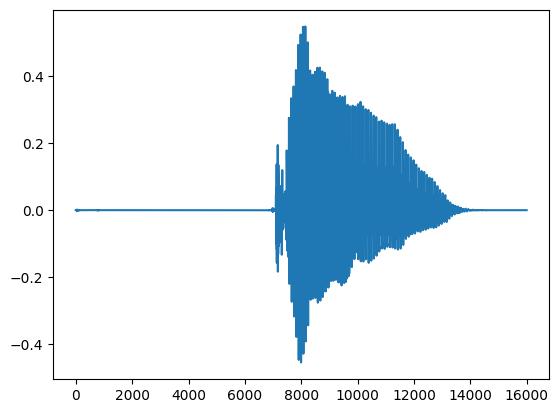

In [16]:
nbpat=50
data = patterns[nbpat].signal
samplerate=16000
plt.plot(data)
plt.show()

In [17]:
audio=Audio(data=data,rate=samplerate,autoplay=False)
audio

Simple function to display a spectrogram. It is adapted from a SciPy example.

In [18]:
def get_spectrogram(waveform,fs):
    # Zero-padding for an audio waveform with less than 16,000 samples.
    input_len = 16000
    waveform = waveform[:input_len]
    zero_padding = np.zeros(
      16000 - waveform.shape[0],
      dtype=np.float32)
    mmax=np.max(np.abs(waveform))
    
    equal_length = np.hstack([waveform, zero_padding])
    f, t, Zxx = scipy.signal.stft(equal_length, fs, nperseg=1000)
    plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=mmax/100, shading='gouraud')
    plt.title('STFT Magnitude')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()

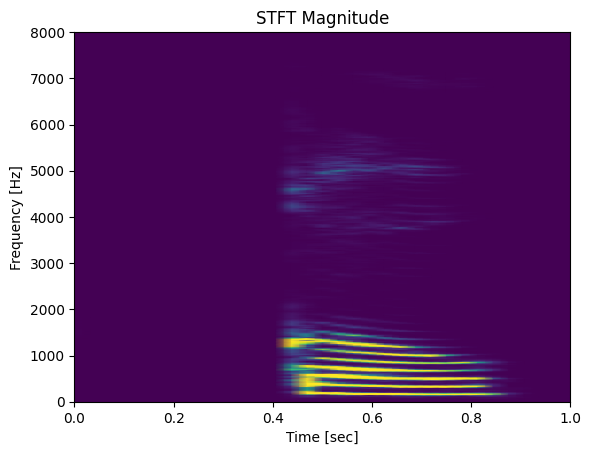

In [19]:
get_spectrogram(data,16000)

Display of the feature to compare with the spectrogram.

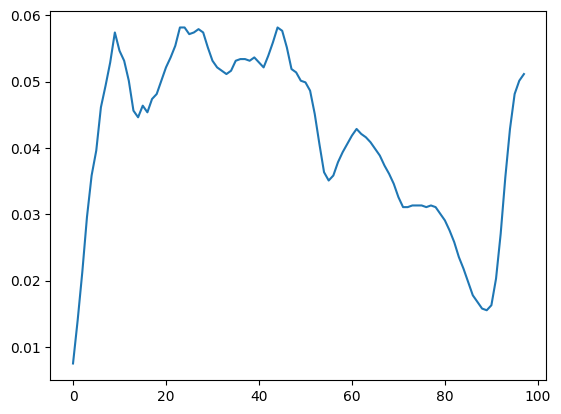

In [20]:
feat=feature(data)
plt.plot(feat)
plt.show()

## Patterns for training

Now we generate the arrays needed to train and test the model.
We have an array of feature : X_array.
An array of label ID : y

and similar arrays for the tests.

In [21]:
X=np.array([x.feature for x in train_patterns])
X.shape

(1600, 98)

In [22]:
y=np.array([x.label for x in train_patterns])
y.shape

(1600,)

In [23]:
y_test = [x.label for x in test_patterns]
X_test = [x.feature for x in test_patterns]

## Logistic Regression

We have chosen to use a simple logistic regression. We are doing a randomized search on the hyperparameter space.

In [24]:
distributionsb = dict(C=uniform(loc=1, scale=1000)
                    )
reg = LogisticRegression(penalty="l1", solver="saga", tol=0.1)
clfb=RandomizedSearchCV(reg, distributionsb,random_state=0,n_iter=50).fit(X, y)

We are using the best estimator found during the randomized search:

In [25]:
clfb.best_estimator_

LogisticRegression(C=np.float64(682.8202991034834), penalty='l1', solver='saga',
                   tol=0.1)

The confusion matrix is generated from the test patterns to check the behavior of the classifier:

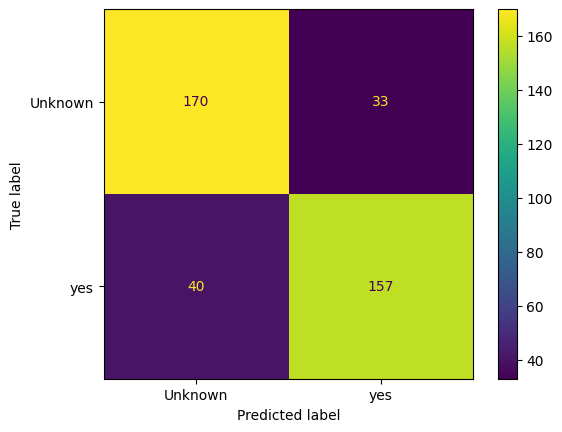

In [26]:
y_pred = clfb.predict(X_test)
labels=["Unknown"] + to_keep
ConfusionMatrixDisplay.from_predictions(y_test, y_pred,display_labels=labels)

We compute the final score. 0.8 is really the minimum acceptable value for this kind of demo.
With the zcr feature, if you try to detect `Yes`, `No`, `Unknown`, you'll get a score of around 0.6 which is very bad.

In [27]:
clfb.score(X_test, y_test)

0.8175

We can now save the model so that next time we want to play with the notebook and test the CMSIS-DSP implementation we do not have to retrain the model:

In [28]:
with open("logistic.pickle","wb") as f:
    s = pickle.dump(clfb,f)

And we can reload the saved model:

In [197]:
with open("logistic.pickle","rb") as f:
    clfb=pickle.load(f)

## Reference implementation with Matrix

This is the reference implementation which will be used to build the CMSIS-DSP implementation. We are no more using the scikit-learn predict function instead we are using an implementation of predict using linear algebra. It should give the same results.

In [29]:
def predict(feat):
    coef=clfb.best_estimator_.coef_
    intercept=clfb.best_estimator_.intercept_
    
    res=np.dot(coef,feat) + intercept
    
    if res<0:
        return(-1)
    else:
        return(0)

And like in the code above with scikit-learn, we are checking the result with the confusion matrix and the score. It should give the same results:

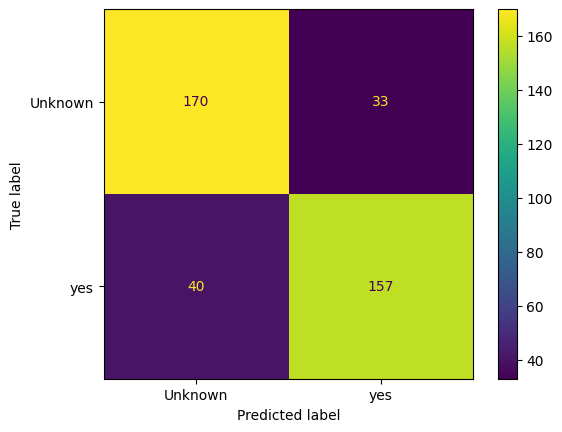

In [30]:
y_pred_ref = [predict(x) for x in X_test]
labels=["Unknown"] + to_keep
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_ref,display_labels=labels)

In [31]:
np.count_nonzero(np.equal(y_test,y_pred_ref))/len(y_test)

0.8175

## CMSIS-DSP implementation

Now we are ready to implement the code using CMSIS-DSP API. Once we have a running implementation in Python, writing the C code will be easy since the API is the same.

We are testing 3 implementations here : F32, Q31 and Q15.
At the end, we will check that Q15 is giving good enough results and thus can be implemented in C for the Arduino.

### F32 Implementation

It will be very similar to the implementation above with matrix but will instead use the CMSIS-DSP API.

In [32]:
coef_f32=clfb.best_estimator_.coef_
intercept_f32=clfb.best_estimator_.intercept_

In [33]:
def dsp_zcr(w):
    m = dsp.arm_mean_f32(w)
    m = -m
    w = dsp.arm_offset_f32(w,m)
    f=w[:-1]
    g=w[1:]
    k=np.count_nonzero(np.logical_and(f*g<0, g>f))
    return(1.0*k/len(f))

For the FIR, CMSIS-DSP is using a FIR instance structure and thus we need to define it

In [34]:
firf32 = dsp.arm_fir_instance_f32()

In [35]:
def dsp_feature(data):
    samplerate=16000
    input_len = 16000
    
    waveform = data[:input_len]
    
    zero_padding = np.zeros(
      16000 - waveform.shape[0],
      dtype=np.float32)
   
   
    signal = np.hstack([waveform, zero_padding])
    
    
    winDuration=25e-3
    audioOffsetDuration=10e-3
    winLength=int(np.floor(samplerate*winDuration))
    audioOffset=int(np.floor(samplerate*audioOffsetDuration))
    overlap=winLength -audioOffset
    window=hann(winLength,sym=False)
    reta=[dsp_zcr(dsp.arm_mult_f32(x,window)) for x in sliding_window_view(signal,winLength)[::audioOffset,:]]
    
    # Reset state and filter
    # We want to start with a clean filter each time we filter a new feature.
    # So the filter state is reset each time.
    blockSize=98
    numTaps=10
    stateLength = numTaps + blockSize - 1
    dsp.arm_fir_init_f32(firf32,10,np.ones(10)/10.0,np.zeros(stateLength))
    reta=dsp.arm_fir_f32(firf32,reta)
    return(np.array(reta))

Let's check that the feature is giving the same result as the reference implemenattion using linear algebra.

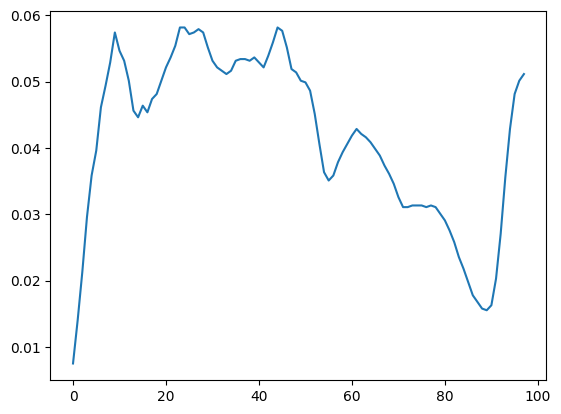

In [36]:
feat=dsp_feature(data)
plt.plot(feat)
plt.show()

The feature code is working, so now we can implement the predict:

In [37]:
def dsp_predict(feat):
    
    res=dsp.arm_dot_prod_f32(coef_f32,feat)
    res = res + intercept_f32
    
    if res[0]<0:
        return(-1)
    else:
        return(0)

And finally we can check the CMSIS-DSP behavior of the test patterns:

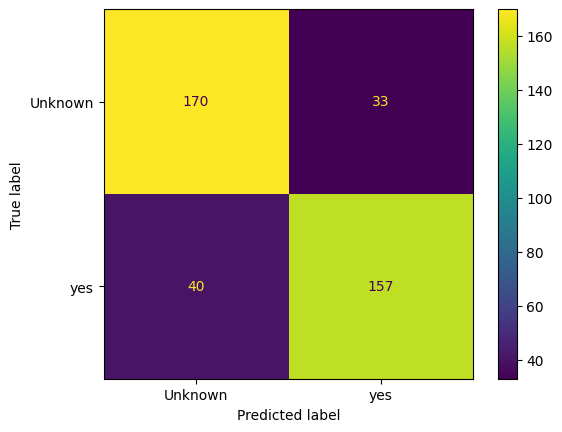

In [38]:
y_pred_ref = [dsp_predict(dsp_feature(x.signal)) for x in test_patterns]
labels=["Unknown"] + to_keep
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_ref,display_labels=labels)

In [39]:
np.count_nonzero(np.equal(y_test,y_pred_ref))/len(y_test)

0.8175

We are getting very similar results to the reference implementation. Now let's explore fixed point.

### Q31 implementation

First thing to do is to convert the F32 values of the ML mode into Q31.
But we need values in [-1,1]. So we rescale those values and keep track of the shift required to restore the original value.

Then, we convert those rescaled values to Q31.

In [40]:
scaled_coef=clfb.best_estimator_.coef_ 
coef_shift=0
while np.max(np.abs(scaled_coef)) > 1:
    scaled_coef = scaled_coef / 2.0 
    coef_shift = coef_shift + 1

coef_q31=fix.toQ31(scaled_coef)

scaled_intercept = clfb.best_estimator_.intercept_ 
intercept_shift = 0
while np.abs(scaled_intercept) > 1:
    scaled_intercept = scaled_intercept / 2.0 
    intercept_shift = intercept_shift + 1
    
intercept_q31=fix.toQ31(scaled_intercept)

Now we can implement the zcr and feature in Q31.

In [41]:
def dsp_zcr_q31(w):
    m = dsp.arm_mean_q31(w)
    # Negate can saturate so we use CMSIS-DSP function which is working on array (and we have a scalar)
    m = dsp.arm_negate_q31(np.array([m]))[0]
    w = dsp.arm_offset_q31(w,m)
    
    f=w[:-1]
    g=w[1:]
    k=np.count_nonzero(np.logical_and(np.logical_or(np.logical_and(f>0,g<0), np.logical_and(f<0,g>0)),g>f))
    
    # k < len(f) so shift should be 0 except when k == len(f)
    # When k==len(f) normally quotient is 0x40000000 and shift 1 and we convert
    # this to 0x7FFFFFF and shift 0
    status,quotient,shift_val=dsp.arm_divide_q31(k,len(f))
    if shift_val==1:
        return(dsp.arm_shift_q31(np.array([quotient]),shift)[0])
    else:
        return(quotient)

In [42]:
firq31 = dsp.arm_fir_instance_q31()

In [43]:
def dsp_feature_q31(data):
    samplerate=16000
    input_len = 16000
    
    waveform = data[:input_len]
    
    zero_padding = np.zeros(
      16000 - waveform.shape[0],
      dtype=np.int32)
   
   
    signal = np.hstack([waveform, zero_padding])
    
    
    winDuration=25e-3
    audioOffsetDuration=10e-3
    winLength=int(np.floor(samplerate*winDuration))
    audioOffset=int(np.floor(samplerate*audioOffsetDuration))
    overlap=winLength-audioOffset
    
    window=fix.toQ31(hann(winLength,sym=False))
    reta=[dsp_zcr_q31(dsp.arm_mult_q31(x,window)) for x in sliding_window_view(signal,winLength)[::audioOffset,:]]
    
    # Reset state and filter
    blockSize=98
    numTaps=10
    stateLength = numTaps + blockSize - 1
    dsp.arm_fir_init_q31(firq31,10,fix.toQ31(np.ones(10)/10.0),np.zeros(stateLength,dtype=np.int32))
    reta=dsp.arm_fir_q31(firq31,reta)
    return(np.array(reta))

Let's check the feature on the data to compare with the F32 version and check it is working:

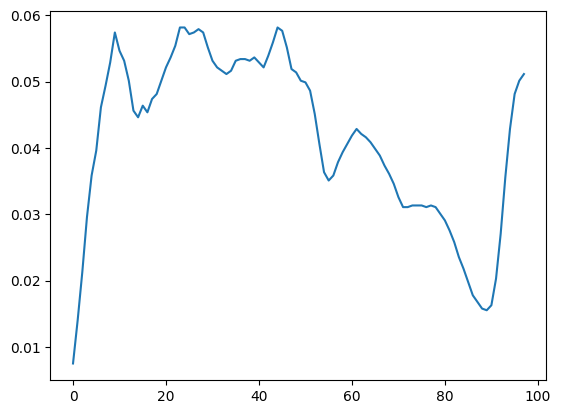

In [44]:
feat=fix.Q31toF32(dsp_feature_q31(fix.toQ31(data)))
plt.plot(feat)
plt.show()

The Q31 feature is very similar to the F32 one so now we can implement the predict:

In [45]:
def dsp_predict_q31(feat):
    
    res=dsp.arm_dot_prod_q31(coef_q31,feat)
    
    # Before adding the res and the intercept we need to ensure they are in the same Qx.x format
    # The scaling applied to the coefs and to the intercept is different so we need to scale
    # the intercept to take this into account
    scaled=dsp.arm_shift_q31(np.array([intercept_q31]),intercept_shift-coef_shift)[0]
    # Because dot prod output is in Q16.48
    # and ret is on 64 bits
    scaled = np.int64(scaled) << 17 
    
    res = res + scaled
    
   
    
    if res<0:
        return(-1)
    else:
        return(0)

Now we can check the Q31 implementation on the test patterns:

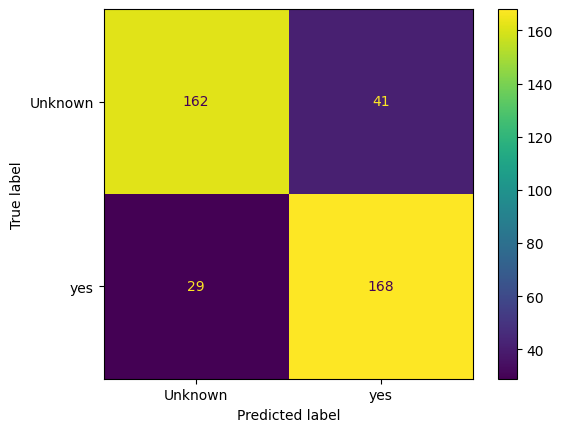

In [46]:
y_pred_ref = [dsp_predict_q31(dsp_feature_q31(fix.toQ31(x.signal))) for x in test_patterns]
labels=["Unknown"] + to_keep
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_ref,display_labels=labels)

In [47]:
np.count_nonzero(np.equal(y_test,y_pred_ref))/len(y_test)

0.825

The score is as good as the F32 implementation.

### Q15 Implementation

It is the same as Q31 but using Q15 functions.

In [48]:
scaled_coef=clfb.best_estimator_.coef_ 
coef_shift=0
while np.max(np.abs(scaled_coef)) > 1:
    scaled_coef = scaled_coef / 2.0 
    coef_shift = coef_shift + 1

coef_q15=fix.toQ15(scaled_coef)

scaled_intercept = clfb.best_estimator_.intercept_ 
intercept_shift = 0
while np.abs(scaled_intercept) > 1:
    scaled_intercept = scaled_intercept / 2.0 
    intercept_shift = intercept_shift + 1
    
intercept_q15=fix.toQ15(scaled_intercept)

In [49]:
def dsp_zcr_q15(w):
    m = dsp.arm_mean_q15(w)
    # Negate can saturate so we use CMSIS-DSP function which is working on array (and we have a scalar)
    m = dsp.arm_negate_q15(np.array([m]))[0]
    w = dsp.arm_offset_q15(w,m)
    
    f=w[:-1]
    g=w[1:]
    k=np.count_nonzero(np.logical_and(np.logical_or(np.logical_and(f>0,g<0), np.logical_and(f<0,g>0)),g>f))
    
    # k < len(f) so shift should be 0 except when k == len(f)
    # When k==len(f) normally quotient is 0x4000 and shift 1 and we convert
    # this to 0x7FFF and shift 0
    status,quotient,shift_val=dsp.arm_divide_q15(k,len(f))
    if shift_val==1:
        return(dsp.arm_shift_q15(np.array([quotient]),shift)[0])
    else:
        return(quotient)

In [50]:
firq15 = dsp.arm_fir_instance_q15()

In [51]:
def dsp_feature_q15(data):
    samplerate=16000
    input_len = 16000
    
    waveform = data[:input_len]
    
    zero_padding = np.zeros(
      16000 - waveform.shape[0],
      dtype=np.int16)
   
   
    signal = np.hstack([waveform, zero_padding])
    
    
    winDuration=25e-3
    audioOffsetDuration=10e-3
    winLength=int(np.floor(samplerate*winDuration))
    audioOffset=int(np.floor(samplerate*audioOffsetDuration))
    overlap=winLength - audioOffset
    
    window=fix.toQ15(hann(winLength,sym=False))
    reta=[dsp_zcr_q15(dsp.arm_mult_q15(x,window)) for x in sliding_window_view(signal,winLength)[::audioOffset,:]]
    
    # Reset state and filter
    blockSize=98
    numTaps=10
    stateLength = numTaps + blockSize - 1
    dsp.arm_fir_init_q15(firq15,10,fix.toQ15(np.ones(10)/10.0),np.zeros(stateLength,dtype=np.int16))
    reta=dsp.arm_fir_q15(firq15,reta)
    return(np.array(reta))

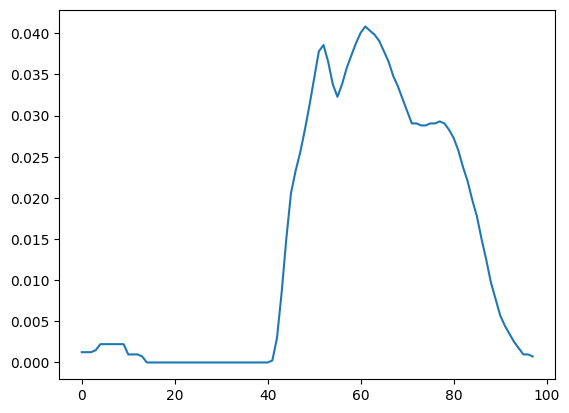

In [52]:
feat=fix.Q15toF32(dsp_feature_q15(fix.toQ15(data)))
plt.plot(feat)
plt.show()

In [53]:
def dsp_predict_q15(feat):
    
    res=dsp.arm_dot_prod_q15(coef_q15,feat)
    
    scaled=dsp.arm_shift_q15(np.array([intercept_q15]),intercept_shift-coef_shift)[0]
    # Because dot prod output is in Q34.30
    # and ret is on 64 bits
    scaled = np.int64(scaled) << 15 
    
    res = res + scaled
    
   
    
    if res<0:
        return(-1)
    else:
        return(0)

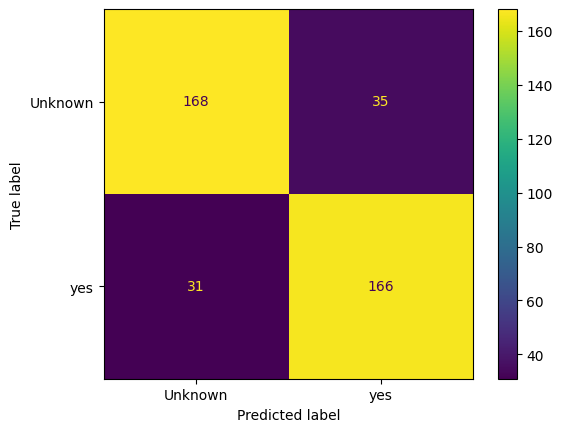

In [54]:
y_pred_ref = [dsp_predict_q15(dsp_feature_q15(fix.toQ15(x.signal))) for x in test_patterns]
labels=["Unknown"] + to_keep
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_ref,display_labels=labels)

In [55]:
np.count_nonzero(np.equal(y_test,y_pred_ref))/len(y_test)

0.835

Q15 version is as good as other versions so we are selecting this implementation to run on the Arduino (once it has been converted to C).